# Delta-Energy Analysis on Synthesized Math Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DEV = 'cuda'

In [3]:
# set LaTeX fonts for matplotlib
# and change default colors to qualitative set2
import matplotlib.pyplot as plt

import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams.update(
    {
        "text.usetex": True,  # Use LaTeX for text rendering
        "font.family": "serif",  # Use serif fonts
        "axes.prop_cycle": plt.cycler("color", plt.cm.Set2.colors)
    }
)

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [4]:
# load llama-2-hf model from huggingface and quantize it
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)

# change the model here
model_name = "meta-llama/Meta-Llama-3-8B" #lmsys/vicuna-7b-v1.5" #"meta-llama/Meta-Llama-3-8B" #meta-llama/Llama-2-7b-hf" "Qwen/Qwen3-8B" "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token

## Math Synthetic Dataset

In [5]:
# generate a dataset of 1000 samples, testing math abilities
import numpy as np

# generate a dataset of 1000 samples, testing math abilities
# containing both correct and incorrect math expressions
def generate_dataset(n_samples=1000, min_val=10000, interval=100, err_range=[1, 10], seed=42):
    dataset = []
    # n_samples random numbers between 1 and n_samples without replacement
    from numpy.random import default_rng
    # set numpy random seed
    np.random.seed(seed)

    rng = default_rng(seed=seed)
    a = rng.integers(min_val, min_val + interval, n_samples)
    b = rng.integers(min_val, min_val + interval, n_samples)
    sign = rng.choice([-1, 1], n_samples)
    
    for i in range(n_samples):
        correct = a[i] + b[i]
        # pick either positive or negative sign
        incorrect = a[i] + b[i] + sign[i]* np.random.randint(*err_range)
        dataset.append({
            "input": f"Solve the following math expression: {a[i]}+{b[i]}=x.\n Answer: x is ",
            "target": str(correct),
            "incorrect": str(incorrect),
            "error": abs(correct - incorrect)
        })
    return dataset

In [6]:
# generate a dataset of 1000 samples
datasets = {
    "1e8": {
        "100_100000": generate_dataset(1000, min_val=100_000_000, interval=499_999_999, err_range=[100, 100_000]),
        "10_100": generate_dataset(1000, min_val=100_000_000, interval=499_999_999, err_range=[10, 100]),
        "1_10": generate_dataset(1000, min_val=100_000_000, interval=499_999_999, err_range=[1, 10]),
    },
    "1e11": {
        #"1000_10000": generate_dataset(1000, min_val=100_000_000_000, interval=499_999_999, err_range=[1000, 10000]),
        #"100_1000": generate_dataset(1000, min_val=100_000_000_000, interval=499_999_999, err_range=[100, 1000]),
        #"1_5": generate_dataset(1000, min_val=100_000_000_000, interval=499_999_999, err_range=[1, 5]),
        "1_10": generate_dataset(1000, min_val=100_000_000_000, interval=499_999_999, err_range=[1, 10]),
    },
    "1e13": {
        #"1000_10000": generate_dataset(1000, min_val=10_000_000_000_000, interval=49_999_999_999, err_range=[1000, 10000]),
        #"100_1000": generate_dataset(1000, min_val=10_000_000_000_000, interval=49_999_999_999, err_range=[100, 1000]),
        "1_10": generate_dataset(1000, min_val=10_000_000_000_000, interval=49_999_999_999, err_range=[1, 10]),
    }
}
correct_datasets = {}
incorrect_datasets = {}

for key1 in datasets:
    correct_datasets[key1] = {}
    incorrect_datasets[key1] = {}
    for key2 in datasets[key1]:
        dataset = datasets[key1][key2]
        correct_datasets[key1][key2] = [d["input"] + d["target"] for d in dataset]
        incorrect_datasets[key1][key2] = [d["input"] + d["incorrect"] for d in dataset]

## Spilled Energy Definition

In [7]:
from spilled_energy.energy import spilled_energy
from spilled_energy.utils import compute_logits_batch, remove_pad_tokens_from_logits

## Energies and Delta-Energies Calculations

In [ ]:
correct_logits = {}
incorrect_logits = {}
correct_ids = {}
incorrect_ids = {}

# look for existing logits on disk
import os
import pickle
logits_exist = True
for key1 in correct_datasets:
    for key2 in correct_datasets[key1]:
        output_dir = f"outputs/math_synth/{model_name.split('/')[-1]}"
        if not os.path.exists(f"{output_dir}/{key1}_{key2}_correct_logits.pkl") or not os.path.exists(f"{output_dir}/{key1}_{key2}_incorrect_logits.pkl"):
            logits_exist = False
            break
    if not logits_exist:
        break

if logits_exist:
    print("Logits already exist on disk, loading them...")
    for key1 in correct_datasets:
        correct_logits[key1] = {}
        incorrect_logits[key1] = {}
        correct_ids[key1] = {}
        incorrect_ids[key1] = {}
        for key2 in correct_datasets[key1]:
            output_dir = f"outputs/math_synth/{model_name.split('/')[-1]}"
            correct_logits[key1][key2] = pickle.load(open(f"{output_dir}/{key1}_{key2}_correct_logits.pkl", "rb"))
            incorrect_logits[key1][key2] = pickle.load(open(f"{output_dir}/{key1}_{key2}_incorrect_logits.pkl", "rb"))
            correct_ids[key1][key2] = pickle.load(open(f"{output_dir}/{key1}_{key2}_correct_ids.pkl", "rb"))
            incorrect_ids[key1][key2] = pickle.load(open(f"{output_dir}/{key1}_{key2}_incorrect_ids.pkl", "rb"))
else:
    output_dir = f"outputs/math_synth/{model_name.split('/')[-1]}"
    os.makedirs(output_dir, exist_ok=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=nf4_config, device_map=DEV)
    # compute logits for correct and incorrect dataset
    print("Computing logits for dataset with correct math expressions")
    for key1 in correct_datasets:
        correct_logits[key1] = {}
        correct_ids[key1] = {}
        for key2 in correct_datasets[key1]:
            dataset = correct_datasets[key1][key2]
            correct_logits[key1][key2], correct_ids[key1][key2] = compute_logits_batch(dataset, tokenizer, model, bs=32)
            pickle.dump(correct_logits[key1][key2], open(f"{output_dir}/{key1}_{key2}_correct_logits.pkl", "wb"))
            pickle.dump(correct_ids[key1][key2], open(f"{output_dir}/{key1}_{key2}_correct_ids.pkl", "wb"))

    print("Computing logits for dataset with incorrect math expressions")
    for key1 in incorrect_datasets:
        incorrect_logits[key1] = {}
        incorrect_ids[key1] = {}
        for key2 in incorrect_datasets[key1]:
            dataset = incorrect_datasets[key1][key2]
            incorrect_logits[key1][key2], incorrect_ids[key1][key2] = compute_logits_batch(dataset, tokenizer, model, bs=32)
            pickle.dump(incorrect_logits[key1][key2], open(f"{output_dir}/{key1}_{key2}_incorrect_logits.pkl", "wb"))
            pickle.dump(incorrect_ids[key1][key2], open(f"{output_dir}/{key1}_{key2}_incorrect_ids.pkl", "wb"))


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Computing logits for dataset with correct math expressions


  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
for key1 in correct_logits:
    for key2 in correct_logits[key1]:
        correct_logits[key1][key2], correct_ids[key1][key2] = remove_pad_tokens_from_logits(correct_logits[key1][key2], correct_ids[key1][key2], tokenizer, tokenizer.padding_side)

for key1 in incorrect_logits:
    for key2 in incorrect_logits[key1]:
        incorrect_logits[key1][key2], incorrect_ids[key1][key2] = remove_pad_tokens_from_logits(incorrect_logits[key1][key2], incorrect_ids[key1][key2], tokenizer, tokenizer.padding_side)

In [ ]:
from spilled_energy.utils import compute_joint_p_sequence

joint_p_correct = {}
joint_p_incorrect = {}

for key1 in correct_logits:
    joint_p_correct[key1] = {}
    joint_p_incorrect[key1] = {}
    for key2 in correct_logits[key1]:
        joint_p_correct[key1][key2] = compute_joint_p_sequence(correct_logits[key1][key2], correct_ids[key1][key2])
        joint_p_incorrect[key1][key2] = compute_joint_p_sequence(incorrect_logits[key1][key2], incorrect_ids[key1][key2])

In [ ]:
spilled_energies_correct = {}
spilled_energies_incorrect = {}

e_seq_margin_corr = {}
e_seq_margin_incorr = {}

e_seq_incorr = {}
e_seq_corr = {}

for key1 in correct_logits:
    spilled_energies_correct[key1] = {}
    e_seq_margin_corr[key1] = {}
    e_seq_corr[key1] = {}

    spilled_energies_incorrect[key1] = {}
    e_seq_margin_incorr[key1] = {}
    e_seq_incorr[key1] = {}
    
    for key2 in correct_logits[key1]:
        spilled_energies_correct[key1][key2], e_seq_margin_corr[key1][key2], e_seq_corr[key1][key2] = spilled_energy(correct_logits[key1][key2], correct_ids[key1][key2])
        spilled_energies_incorrect[key1][key2], e_seq_margin_incorr[key1][key2], e_seq_incorr[key1][key2] = spilled_energy(incorrect_logits[key1][key2], incorrect_ids[key1][key2])

## Quantitative Analysis

In [ ]:
corr_answers_delta = {}
incorr_answers_delta = {}

for key1 in spilled_energies_correct:
    corr_answers_delta[key1] = {}
    incorr_answers_delta[key1] = {}
    for key2 in spilled_energies_correct[key1]:
        dataset = datasets[key1][key2]
        # find each question length for the dataset using tokenizer
        questions = [d["input"] for d in dataset]
        question_lengths = [len(tokenizer(q)["input_ids"]) for q in questions]

        # extract spilled_energies for correct and incorrect answers using question_lengths
        corr_answers_delta[key1][key2] = []
        incorr_answers_delta[key1][key2] = []

        for i in range(len(spilled_energies_correct[key1][key2])):
            corr_answers_delta[key1][key2].append(np.mean(spilled_energies_correct[key1][key2][i][question_lengths[i]:]))
            incorr_answers_delta[key1][key2].append(np.mean(spilled_energies_incorrect[key1][key2][i][question_lengths[i]:]))

### Delta-Energy

Spilled Energy for Correct and Incorrect Answers - 1e8 100_100000


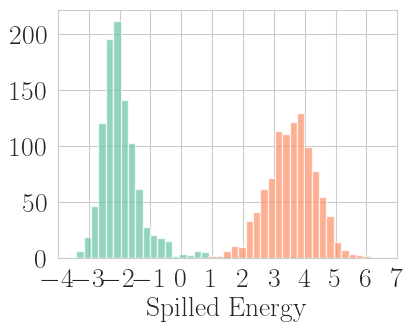

Spilled Energy for Correct and Incorrect Answers - 1e8 10_100


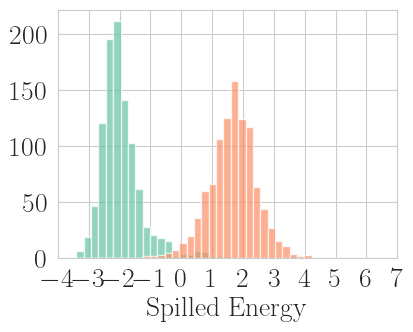

Spilled Energy for Correct and Incorrect Answers - 1e8 1_10


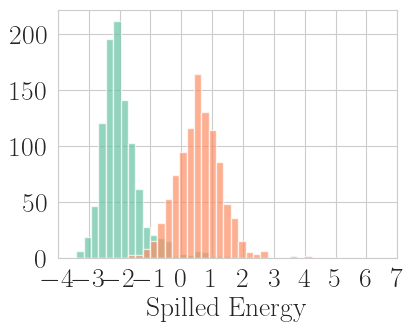

Spilled Energy for Correct and Incorrect Answers - 1e11 1_10


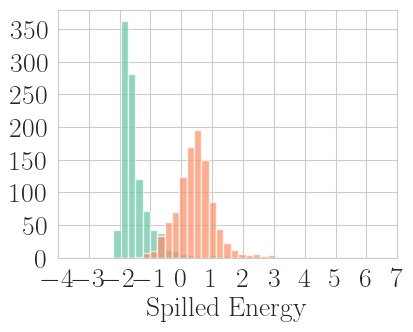

Spilled Energy for Correct and Incorrect Answers - 1e13 1_10


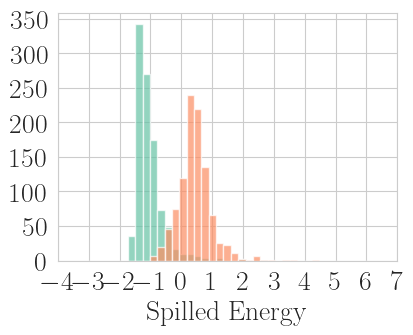

In [ ]:
# plot with an histogram the delta energies for correct and incorrect answers
# with seaborn
bins = np.histogram_bin_edges([val for sublist in corr_answers_delta.values() for subsublist in sublist.values() for val in subsublist] +
                              [val for sublist in incorr_answers_delta.values() for subsublist in sublist.values() for val in subsublist], bins=40)

# for xlim take the min integer and max integer of both correct and incorrect answers for all key1 and key2
# and set xlim to be from min-1 to max+1
# and set xticks to be from min-1 to max+1 with step
all_values = [val for sublist in corr_answers_delta.values() for subsublist in sublist.values() for val in subsublist] + \
             [val for sublist in incorr_answers_delta.values() for subsublist in sublist.values() for val in subsublist]
min_val = int(np.floor(min(all_values)))
max_val = int(np.ceil(max(all_values)))
step = 1 if max_val - min_val < 10 else (max_val - min_val) // 10

for key1 in corr_answers_delta:
  for key2 in corr_answers_delta[key1]:
    fig = plt.figure(figsize=(4, 3))
    plt.hist(corr_answers_delta[key1][key2], bins=bins, alpha=0.7, label="Correct")
    plt.hist(incorr_answers_delta[key1][key2], bins=bins, alpha=0.7, label="Incorrect")
    print(f"Spilled Energy for Correct and Incorrect Answers - {key1} {key2}")
    #plt.legend(fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.xticks(fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    

    plt.xlim(min_val, max_val)
    plt.xticks(np.arange(min_val, max_val+1, step))
    plt.xlabel("Spilled Energy", fontsize=20, fontweight='bold')
    os.makedirs(f"plots/synth_maths/{model_name.split('/')[-1]}", exist_ok=True)
    plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/spilled_energy_correct_incorrect_answers_histogram_{key1}_{key2}.pdf", bbox_inches='tight')
    plt.show()


Spilled Energy for Correct and Incorrect Answers - 1e8 100_100000


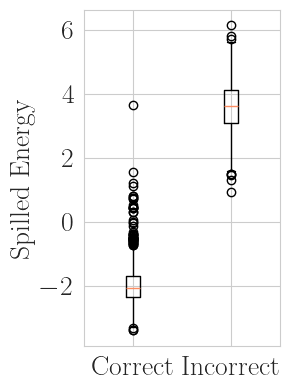

Spilled Energy for Correct and Incorrect Answers - 1e8 10_100


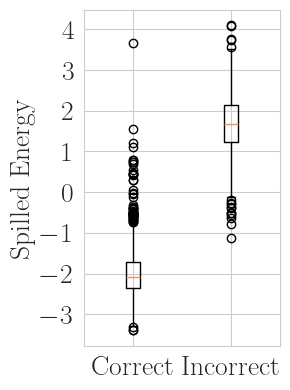

Spilled Energy for Correct and Incorrect Answers - 1e8 1_10


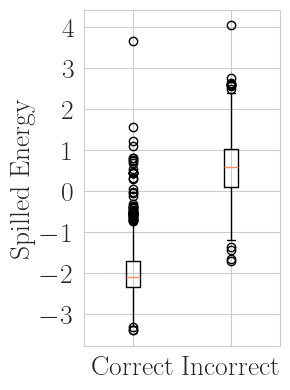

Spilled Energy for Correct and Incorrect Answers - 1e11 1_10


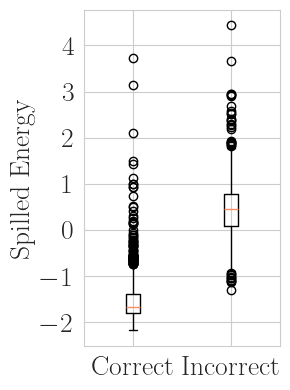

Spilled Energy for Correct and Incorrect Answers - 1e13 1_10


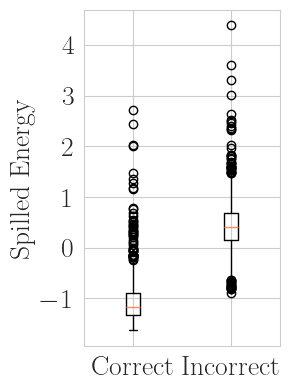

In [ ]:
for key1 in corr_answers_delta:
    for key2 in corr_answers_delta[key1]:
        # plot values of spilled_energies for correct and incorrect answers
        # with standard deviation error bars in a box plot
        # make size of figure 4x3 inches
        plt.gcf().set_size_inches(3, 4)
        plt.boxplot([corr_answers_delta[key1][key2], incorr_answers_delta[key1][key2]], tick_labels=["Correct", "Incorrect"])
        plt.ylabel("Spilled Energy", fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        plt.yticks(fontsize=20, fontweight='bold')
        print(f"Spilled Energy for Correct and Incorrect Answers - {key1} {key2}")
        plt.tight_layout()
        plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/spilled_energy_correct_incorrect_answers_boxplot_{key1}_{key2}.pdf", bbox_inches='tight')
        plt.show()

### Joint Probability

In [ ]:
corr_answers_joint_p = {}
incorr_answers_joint_p = {}

for key1 in corr_answers_delta:
    corr_answers_joint_p[key1] = {}
    incorr_answers_joint_p[key1] = {}
    for key2 in corr_answers_delta[key1]:
        corr_answers_joint_p[key1][key2] = []
        incorr_answers_joint_p[key1][key2] = []
        dataset = datasets[key1][key2]
        # find each question length for the dataset using tokenizer
        questions = [d["input"] for d in dataset]
        question_lengths = [len(tokenizer(q)["input_ids"]) for q in questions]

        # extract joint probabilities for correct and incorrect answers using question_lengths
        corr_answers_joint_p[key1][key2] = []
        incorr_answers_joint_p[key1][key2] = []

        for i in range(len(corr_answers_delta[key1][key2])):
            corr_answers_joint_p[key1][key2].append(np.mean(joint_p_correct[key1][key2][i][question_lengths[i]:]))
            incorr_answers_joint_p[key1][key2].append(np.mean(joint_p_incorrect[key1][key2][i][question_lengths[i]:]))

LogLikelihood on Math Synthesized Data - 1e8 100_100000


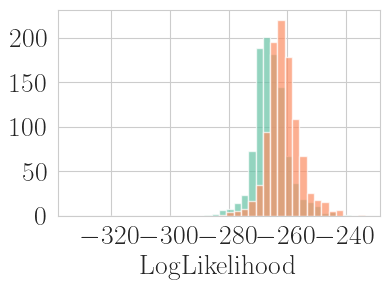

LogLikelihood on Math Synthesized Data - 1e8 10_100


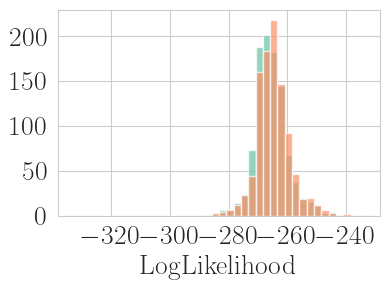

LogLikelihood on Math Synthesized Data - 1e8 1_10


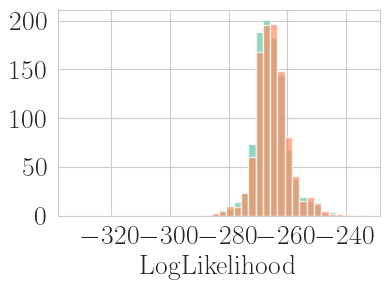

LogLikelihood on Math Synthesized Data - 1e11 1_10


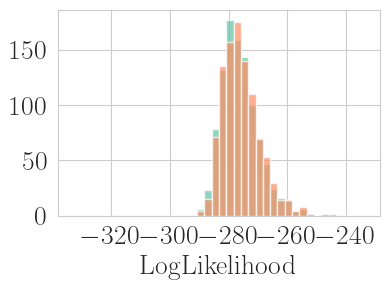

LogLikelihood on Math Synthesized Data - 1e13 1_10


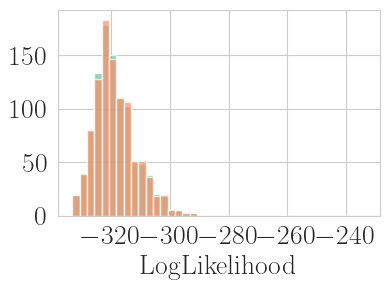

In [ ]:
bins = np.histogram_bin_edges([val for sublist in corr_answers_joint_p.values() for subsublist in sublist.values() for val in subsublist] +
                              [val for sublist in incorr_answers_joint_p.values() for subsublist in sublist.values() for val in subsublist], bins=40)

for key1 in corr_answers_joint_p:
    for key2 in corr_answers_joint_p[key1]:
        # plot histogram of likelihood for correct and incorrect answers
        #make plot size 4x3 inches
        plt.gcf().set_size_inches(4, 3)
        plt.hist(corr_answers_joint_p[key1][key2], bins=bins, alpha=0.7, label="Correct Answers")
        plt.hist(incorr_answers_joint_p[key1][key2], bins=bins, alpha=0.7, label="Incorrect Answers")
        plt.xlabel("LogLikelihood", fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        plt.yticks(fontsize=20, fontweight='bold')
        print(f"LogLikelihood on Math Synthesized Data - {key1} {key2}")
        #legend = plt.legend(fontsize=20, fontweight='bold')
        #legend.get_frame().set_alpha(0.5)
        plt.tight_layout()
        plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/log_likelihood_correct_incorrect_answers_histogram_log_{key1}_{key2}.pdf", bbox_inches='tight')
        plt.show()

### Energies

In [ ]:
corr_answers_energy = {}
incorr_answers_energy = {}

for key1 in e_seq_corr:
    corr_answers_energy[key1] = {}
    incorr_answers_energy[key1] = {}
    for key2 in e_seq_corr[key1]:
        dataset = datasets[key1][key2]
        # find each question length for the dataset using tokenizer
        questions = [d["input"] for d in dataset]
        question_lengths = [len(tokenizer(q)["input_ids"]) for q in questions]
        corr_answers_energy[key1][key2] = [np.mean(e_seq_corr[key1][key2][i][question_lengths[i]-1:]) for i in range(len(questions))]
        incorr_answers_energy[key1][key2] = [np.mean(e_seq_incorr[key1][key2][i][question_lengths[i]-1:]) for i in range(len(questions))]

Energy for Correct and Incorrect Answers - 1e8 100_100000


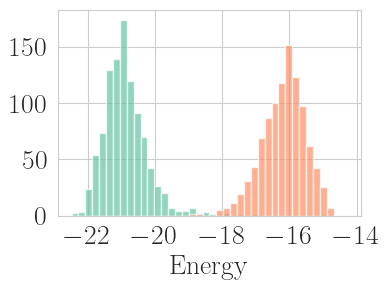

Energy for Correct and Incorrect Answers - 1e8 10_100


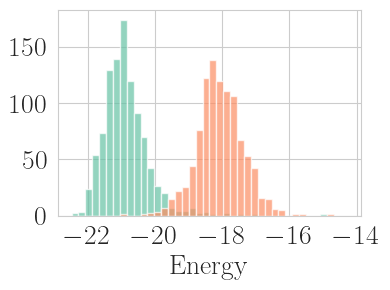

Energy for Correct and Incorrect Answers - 1e8 1_10


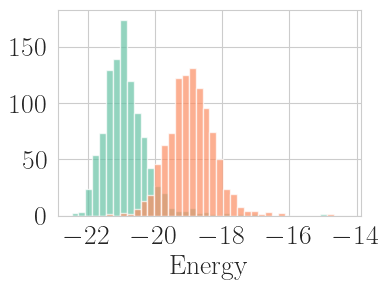

Energy for Correct and Incorrect Answers - 1e11 1_10


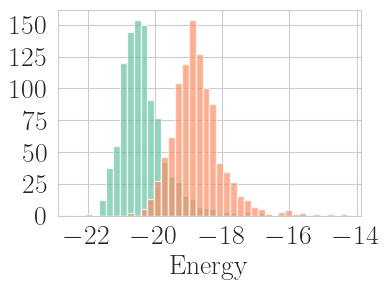

Energy for Correct and Incorrect Answers - 1e13 1_10


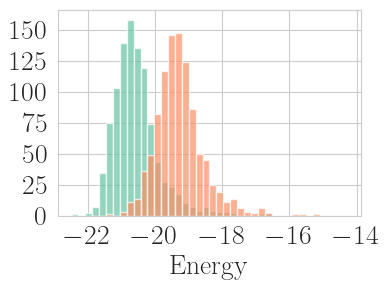

In [ ]:
bins = np.histogram_bin_edges([val for sublist in corr_answers_energy.values() for subsublist in sublist.values() for val in subsublist] +
                              [val for sublist in incorr_answers_energy.values() for subsublist in sublist.values() for val in subsublist], bins=40)

for key1 in corr_answers_energy:
    for key2 in corr_answers_energy[key1]:
        
        plt.hist(corr_answers_energy[key1][key2], bins=bins, alpha=0.7, label="Correct")
        plt.hist(incorr_answers_energy[key1][key2], bins=bins, alpha=0.7, label="Incorrect")
        plt.gcf().set_size_inches(4, 3)
        plt.xlabel("Energy", fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        plt.yticks(fontsize=20, fontweight='bold')
        print(f"Energy for Correct and Incorrect Answers - {key1} {key2}")
        #legend = plt.legend(fontsize=20, fontweight='bold')
        #legend.get_frame().set_alpha(0.5)
        plt.tight_layout()
        plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/energy_correct_incorrect_answers_histogram_{key1}_{key2}.pdf", bbox_inches='tight')
        plt.show()

In [ ]:
# plot histogram of energies marginalized over the next token for correct and incorrect answers
corr_answers_energy_margin = {}
incorr_answers_energy_margin = {}

for key1 in e_seq_margin_corr:
    corr_answers_energy_margin[key1] = {}
    incorr_answers_energy_margin[key1] = {}
    for key2 in e_seq_margin_corr[key1]:
        dataset = datasets[key1][key2]
        # find each question length for the dataset using tokenizer
        questions = [d["input"] for d in dataset]
        question_lengths = [len(tokenizer(q)["input_ids"]) for q in questions]
        corr_answers_energy_margin[key1][key2] = [np.mean(e_seq_margin_corr[key1][key2][i][question_lengths[i]:]) for i in range(len(questions))]
        incorr_answers_energy_margin[key1][key2] = [np.mean(e_seq_margin_incorr[key1][key2][i][question_lengths[i]:]) for i in range(len(questions))]

Energy marginalized over next token for Correct and Incorrect Answers - 1e8 100_100000


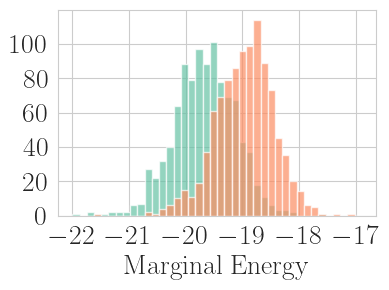

Energy marginalized over next token for Correct and Incorrect Answers - 1e8 10_100


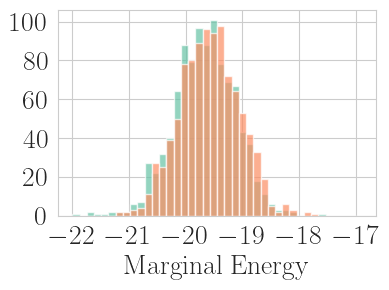

Energy marginalized over next token for Correct and Incorrect Answers - 1e8 1_10


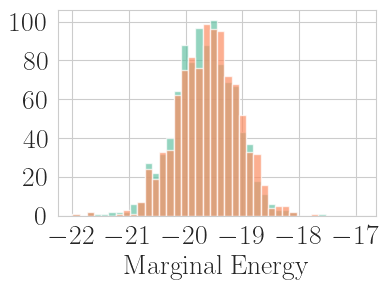

Energy marginalized over next token for Correct and Incorrect Answers - 1e11 1_10


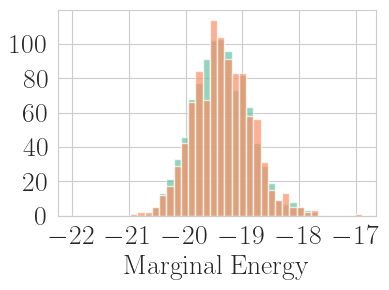

Energy marginalized over next token for Correct and Incorrect Answers - 1e13 1_10


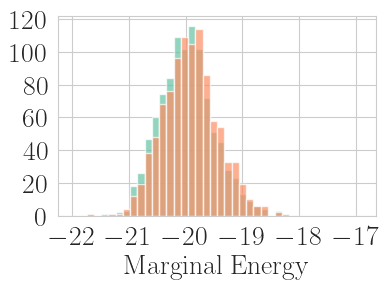

In [ ]:
bins = np.histogram_bin_edges([val for sublist in corr_answers_energy_margin.values() for subsublist in sublist.values() for val in subsublist] +
                              [val for sublist in incorr_answers_energy_margin.values() for subsublist in sublist.values() for val in subsublist], bins=40)

for key1 in corr_answers_energy_margin:
    for key2 in corr_answers_energy_margin[key1]:
        plt.gcf().set_size_inches(4, 3)
        plt.xticks(fontsize=20, fontweight='bold')
        plt.yticks(fontsize=20, fontweight='bold')
        plt.hist(corr_answers_energy_margin[key1][key2], bins=bins, alpha=0.7, label="Correct")
        plt.hist(incorr_answers_energy_margin[key1][key2], bins=bins, alpha=0.7, label="Incorrect")
        plt.xlabel("Marginal Energy", fontsize=20, fontweight='bold')
        print(f"Energy marginalized over next token for Correct and Incorrect Answers - {key1} {key2}")
        #legend = plt.legend(fontsize=20, fontweight='bold')
        #legend.get_frame().set_alpha(0.5)
        plt.tight_layout()
        plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/energy_marginalized_correct_incorrect_answers_histogram_{key1}_{key2}.pdf", bbox_inches='tight')
        plt.show()

### ROC Curves

ROC curve for Hallucination Detection - 1e8 100_100000


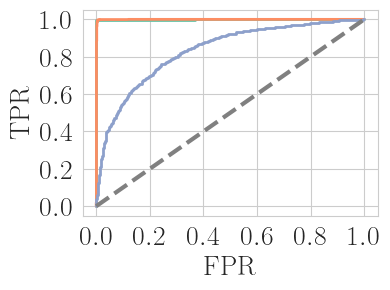

ROC curve for Hallucination Detection - 1e8 10_100


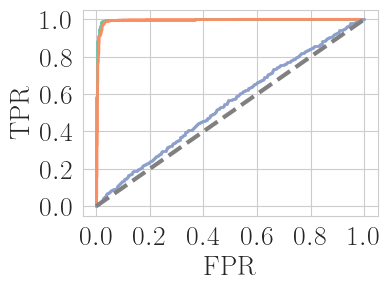

ROC curve for Hallucination Detection - 1e8 1_10


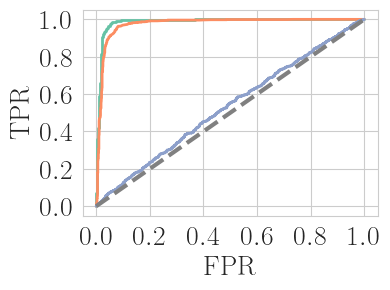

ROC curve for Hallucination Detection - 1e11 1_10


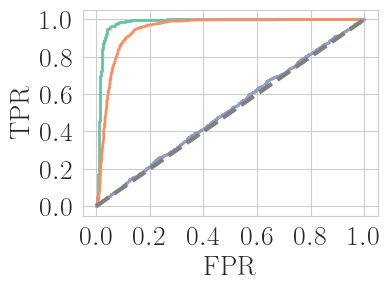

ROC curve for Hallucination Detection - 1e13 1_10


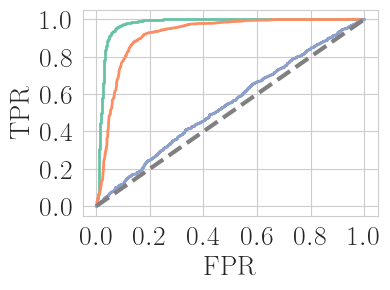

In [ ]:
# plot ROC curves by classifying correct and incorrect answers using Spilled Energy, energy and marginalized energy

for key1 in corr_answers_delta:
    for key2 in corr_answers_delta[key1]:
        plt.gcf().set_size_inches(4,3)
        plt.xticks(fontsize=20, fontweight='bold')
        plt.yticks(fontsize=20, fontweight='bold')
        # create labels for correct and incorrect answers
        y_true = np.zeros(len(corr_answers_delta[key1][key2]) + len(incorr_answers_delta[key1][key2]))
        y_true[len(corr_answers_delta[key1][key2])-1:] = 1

        # concatenate delta energies for correct and incorrect answers
        spilled_energies = np.concatenate([corr_answers_delta[key1][key2], incorr_answers_delta[key1][key2]])

        # compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, spilled_energies)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"Spilled Energy ({roc_auc:.3f})", linewidth=2)

        # concatenate energies for correct and incorrect answers
        energies = np.concatenate([corr_answers_energy[key1][key2], incorr_answers_energy[key1][key2]])

        # compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, energies)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"Energy ({roc_auc:.3f})", linewidth=2)

        # concatenate energies marginalized over the next token for correct and incorrect answers
        energies_margin = np.concatenate([corr_answers_energy_margin[key1][key2], incorr_answers_energy_margin[key1][key2]])

        # compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, energies_margin)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"Energy Marginalized ({roc_auc:.3f})", linewidth=2)

        plt.plot(np.arange(0.0001, 1.01, 0.01), np.arange(0.0001, 1.01, 0.01), linestyle='--', color='gray', label='Random Guessing', linewidth=3)
        plt.xlabel("FPR", fontsize=20, fontweight='bold')
        plt.ylabel("TPR", fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        plt.yticks(fontsize=20, fontweight='bold')
        
        print(f"ROC curve for Hallucination Detection - {key1} {key2}")
        #legend = plt.legend(fontsize=20, loc='upper left')
        #legend.get_frame().set_alpha(0.5)
        plt.tight_layout()
        plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/roc_curve_hallucination_detection_{key1}_{key2}.pdf", bbox_inches='tight')
        plt.show()

ROC curve for Hallucination Detection - 1e8


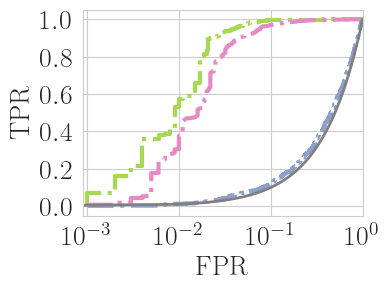

ROC curve for Hallucination Detection - 1e11


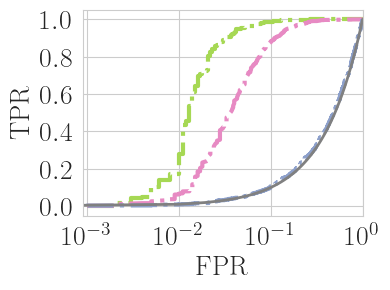

ROC curve for Hallucination Detection - 1e13


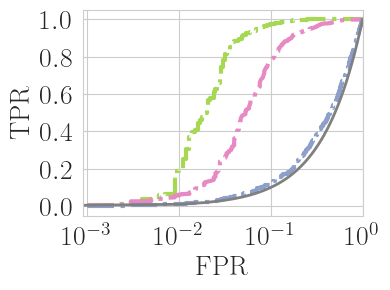

In [ ]:
# make a ROC plot for all three kinds of error ranges in the same plot, using different line styles based on the error range, and same colors for the same method
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Map error ranges to line styles
error_range_styles = {
  "1000_10000": "-",
  "100_1000": ":", 
  "1_10": "-."
}

# Map methods to colors
method_colors = {
  "Spilled Energy": colors[4],
  "Energy": colors[3],
  "Energy Marginalized": colors[2],
  "Random Guessing": "gray"
}

for key1 in corr_answers_delta:
  plt.gcf().set_size_inches(4,3)
  plt.xticks(fontsize=20, fontweight='bold')
  plt.yticks(fontsize=20, fontweight='bold')
  for key2 in corr_answers_delta[key1]:
    if key2 not in error_range_styles:
      continue
    # create labels for correct and incorrect answers
    y_true = np.zeros(len(corr_answers_delta[key1][key2]) + len(incorr_answers_delta[key1][key2]))
    y_true[len(corr_answers_delta[key1][key2])-1:] = 1

    # concatenate delta energies for correct and incorrect answers
    spilled_energies = np.concatenate([corr_answers_delta[key1][key2], incorr_answers_delta[key1][key2]])

    # compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, spilled_energies)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, linestyle=error_range_styles[key2], color=method_colors["Spilled Energy"], label=f"Spilled Energy {key2} ({roc_auc:.3f})", linewidth=3)

    # concatenate energies for correct and incorrect answers
    energies = np.concatenate([corr_answers_energy[key1][key2], incorr_answers_energy[key1][key2]])

    # compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, energies)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, linestyle=error_range_styles[key2], color=method_colors["Energy"], label=f"Energy {key2} ({roc_auc:.3f})", linewidth=3)

    # concatenate energies marginalized over the next token for correct and incorrect answers
    energies_margin = np.concatenate([corr_answers_energy_margin[key1][key2], incorr_answers_energy_margin[key1][key2]])

    # compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, energies_margin)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, linestyle=error_range_styles[key2], color=method_colors["Energy Marginalized"], label=f"Energy Marginalized {key2} ({roc_auc:.3f})", linewidth=3)

  plt.plot(np.arange(0.0001, 1.01, 0.01), np.arange(0.0001, 1.01, 0.01), linestyle='-', color=method_colors["Random Guessing"], label='Random Guessing', linewidth=2)
  plt.xlabel("FPR", fontsize=20, fontweight='bold')
  plt.ylabel("TPR", fontsize=20, fontweight='bold')
  plt.xticks(fontsize=20, fontweight='bold')
  plt.yticks(fontsize=20, fontweight='bold')
  print(f"ROC curve for Hallucination Detection - {key1}")
  
  # Get handles and labels
  handles, labels = plt.gca().get_legend_handles_labels()
  
  # Create a custom sort to group by error range
  sorted_items = []
  
  # First add Random Guessing
  for i, label in enumerate(labels):
    if 'Random' in label:
      sorted_items.append((handles[i], label))
      break
  
  # Then add entries grouped by error range
  for error_range in ["1000_10000", "100_1000", "1_5"]:
    for method in ["Spilled Energy", "Energy", "Energy Marginalized"]:
      for i, label in enumerate(labels):
        if error_range in label and label.startswith(method):
          sorted_items.append((handles[i], label))
          break
  
  sorted_handles, sorted_labels = zip(*sorted_items)
  # make xaxis logarithmic
  plt.xscale("log")
  # start xaxis at 0.001
  plt.xlim(0.0009, 1)
  plt.tight_layout()
  plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/roc_curve_hallucination_detection_all_{key1}.pdf", bbox_inches='tight')
  plt.show()


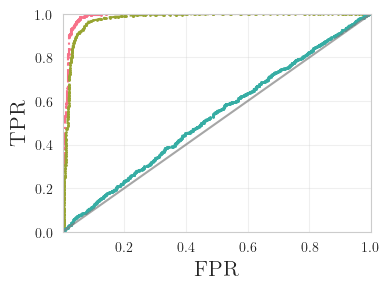

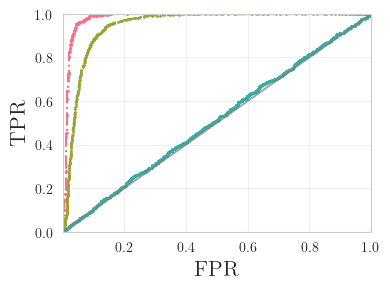

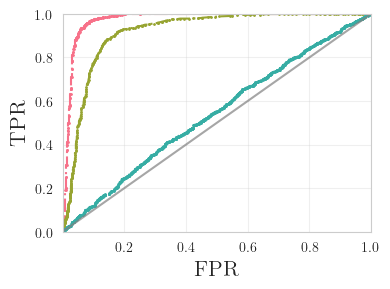

In [ ]:
# Map error ranges to line styles and markers
error_range_styles = {
  "1000_10000": {"linestyle": "-", "marker": "x", "markersize": 1},
  "100_1000": {"linestyle": "--", "marker": "^", "markersize": 1}, 
  "1_10": {"linestyle": "-.", "marker": "o", "markersize": 1}
}

# Map methods to colors using seaborn color palette
palette = sns.color_palette("husl", 4)
method_colors = {
  "Spilled Energy": palette[0],
  "Energy": palette[1],
  "Energy Marginalized": palette[2],
  "Random Guessing": "gray"
}

for key1 in corr_answers_delta:
  plt.figure(figsize=(4,3))
  
  for key2 in corr_answers_delta[key1]:
    # create labels for correct and incorrect answers
    if key2 not in error_range_styles:
      continue
    y_true = np.zeros(len(corr_answers_delta[key1][key2]) + len(incorr_answers_delta[key1][key2]))
    y_true[len(corr_answers_delta[key1][key2]):] = 1

    # concatenate delta energies for correct and incorrect answers
    spilled_energies = np.concatenate([corr_answers_delta[key1][key2], incorr_answers_delta[key1][key2]])

    # compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, spilled_energies)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=method_colors["Spilled Energy"], 
        label=f"Spilled Energy {key2} (AUC={roc_auc:.3f})", 
        **error_range_styles[key2])

    # concatenate energies for correct and incorrect answers
    energies = np.concatenate([corr_answers_energy[key1][key2], incorr_answers_energy[key1][key2]])

    # compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, energies)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=method_colors["Energy"],
        label=f"Energy {key2} (AUC={roc_auc:.3f})", 
        **error_range_styles[key2])

    # concatenate energies marginalized over the next token for correct and incorrect answers
    energies_margin = np.concatenate([corr_answers_energy_margin[key1][key2], incorr_answers_energy_margin[key1][key2]])

    # compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, energies_margin)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=method_colors["Energy Marginalized"],
        label=f"Energy Marginalized {key2} (AUC={roc_auc:.3f})", 
        **error_range_styles[key2])

  plt.plot(np.arange(0.0001, 1.01, 0.01), np.arange(0.0001, 1.01, 0.01), 
      linestyle='-', color=method_colors["Random Guessing"], 
      label='Random Guessing', alpha=0.7)
  
  plt.xlabel("FPR", fontsize=16, fontweight='bold')
  plt.ylabel("TPR", fontsize=16, fontweight='bold')
  
  # Get handles and labels
  handles, labels = plt.gca().get_legend_handles_labels()
  
  # Create a custom sort to group by error range
  sorted_items = []
  
  # First add Random Guessing
  for i, label in enumerate(labels):
    if 'Random' in label:
      sorted_items.append((handles[i], label))
      break
  
  # Then add entries grouped by error range
  for error_range in ["1000_10000", "100_1000", "1_5"]:
    for method in ["Spilled Energy", "Energy", "Energy Marginalized"]:
      for i, label in enumerate(labels):
        if error_range in label and label.startswith(method):
          sorted_items.append((handles[i], label))
          break
  
  sorted_handles, sorted_labels = zip(*sorted_items)
  
  # Style improvements
  plt.grid(True, alpha=0.3)
  #plt.xscale("log")
  plt.xlim(0.0001, 1)
  plt.ylim(0, 1)
  

  plt.tight_layout()
  plt.show()


Spilled Energy for Correct and Incorrect Answers - 1e8 1_10
Spilled Energy for Correct and Incorrect Answers - 1e11 1_10
Spilled Energy for Correct and Incorrect Answers - 1e13 1_10


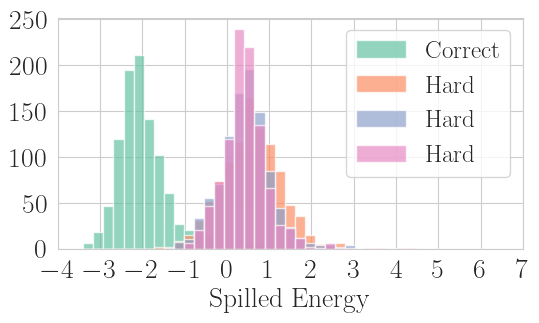

In [ ]:
# first find bins for all delta energies
all_spilled_energies = [corr_answers_delta[key1][key2] for key1 in corr_answers_delta for key2 in corr_answers_delta[key1]] + \
    [incorr_answers_delta[key1][key2] for key1 in incorr_answers_delta for key2 in incorr_answers_delta[key1]]

bins = np.histogram_bin_edges(np.concatenate(all_spilled_energies), bins=40)
min_val = int(np.floor(min(np.concatenate(all_spilled_energies))))
max_val = int(np.ceil(max(np.concatenate(all_spilled_energies))))

figure = plt.figure(figsize=(6,3))
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

key1 = list(corr_answers_delta.keys())[0]
key2 = list(corr_answers_delta[key1].keys())[0]
plt.hist(corr_answers_delta[key1][key2], bins=bins, alpha=0.7, label="Correct")
keyToLabel = {
    "1000_10000": "Easy",
    "100_1000": "Medium",
    "1_10": "Hard"
}

for key1 in corr_answers_delta:
    keys2 = [*corr_answers_delta[key1].keys()]
    keys2.sort()
    keys2.reverse()
    for key2 in keys2:
        if key2 not in error_range_styles:
            continue
        plt.hist(incorr_answers_delta[key1][key2], bins=bins, alpha=0.7, label=f"{keyToLabel[key2]}")
        print(f"Spilled Energy for Correct and Incorrect Answers - {key1} {key2}")

legend = plt.legend(fontsize=18, loc='upper right', ncol=1,)# bbox_to_anchor=(1.25, 1.06))
#legend.get_frame().set_alpha(0.5)
#plt.tight_layout()
#plt.subplots_adjust(bottom=0.15, left=0.12)
plt.xlabel("Spilled Energy", fontsize=20, fontweight='bold')
plt.xlim(min_val, max_val)
# make x ticks integers
plt.xticks(np.arange(min_val, max_val+1, 1))
#plt.ylabel("Frequency", fontsize=20, fontweight='bold')
plt.savefig(f"plots/synth_maths/{model_name.split('/')[-1]}/spilled_energy_correct_incorrect_histogram.pdf", bbox_inches='tight')
plt.show()